In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestRegressor
import os

# Load the dataset
file_path = 'house-prices-advanced-regression-techniques/train.csv'
df = pd.read_csv(file_path)

# Calculate the threshold based on 50% of the number of rows
threshold = len(df) * 0.5

# Drop columns where more than 50% of values are NaN
df = df.dropna(axis=1, thresh=threshold)
df = df.dropna()

# Assuming you have your data loaded into a pandas DataFrame called 'df'
categorical_columns = []
for column in df.columns:
    if df[column].dtype == 'object':
        categorical_columns.append(column)

# Apply One-Hot Encoding to nominal categorical columns
df_enc = pd.get_dummies(df, columns=categorical_columns)

scaler = StandardScaler()
df_enc = pd.DataFrame(scaler.fit_transform(df_enc), columns=df_enc.columns)

y = df_enc['SalePrice']
X = df_enc.drop(['Id', 'SalePrice'], axis=1)

# Step 1: Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Step 2: Feature Selection using Random Forest
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

feature_importances = rf_regressor.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Numbers of top features to select
top_features_list = [1, 10, 50, 100, 125, 175, 200, 225, 289]

results = []

# Create a directory to save the plots
if not os.path.exists('training_plots'):
    os.makedirs('training_plots')

# A function to save the training progress plots
def save_training_plot(history, num_features, depth):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training Progress - {num_features} Features, Depth {depth}')
    plt.legend()
    plot_filename = f'training_plots/regression_RF_training_plot_{num_features}_features_depth_{depth}.png'
    plt.savefig(plot_filename)
    plt.close()

for num_features in top_features_list:
    selected_features = feature_importance_df.head(num_features)['Feature']

    for depth in [5, 10, 15]:
        # Use the selected features
        X_train_subset = X_train[selected_features]
        X_val_subset = X_val[selected_features]
        X_test_subset = X_test[selected_features]

        # Normalize features
        scaler = StandardScaler()
        X_train_subset = scaler.fit_transform(X_train_subset)
        X_val_subset = scaler.transform(X_val_subset)
        X_test_subset = scaler.transform(X_test_subset)

        # Define the neural network model with specified depth
        model = Sequential()
        model.add(Dense(64, activation='relu', input_shape=(len(selected_features),)))
        for _ in range(depth):
            model.add(Dense(32, activation='relu'))
        model.add(Dense(1, activation='linear'))

        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Implement early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True)

        # Train the model
        history = model.fit(
            X_train_subset, y_train,
            validation_data=(X_val_subset, y_val),
            epochs=200, batch_size=32, callbacks=[early_stopping],
            verbose=1
        )
        
        # Save the training progress plot
        save_training_plot(history, num_features, depth)

        # Evaluate the model on the test set using Mean Squared Error (MSE)
        mse = model.evaluate(X_test_subset, y_test, verbose=0)
        results.append({'Num_Features': num_features, 'Depth': depth, 'Final_MSE': mse})

# Save the results table as a CSV file
results_df = pd.DataFrame(results)
results_df.to_csv('results_table.csv', index=False)

print("All plots and results saved successfully.")


Epoch 1/200
12/12 [==============================] - 1s 11ms/step - loss: 1.0546 - val_loss: 0.6657
Epoch 2/200
12/12 [==============================] - 0s 3ms/step - loss: 0.8830 - val_loss: 0.5303
Epoch 3/200
12/12 [==============================] - 0s 3ms/step - loss: 0.7446 - val_loss: 0.4012
Epoch 4/200
12/12 [==============================] - 0s 3ms/step - loss: 0.5532 - val_loss: 0.3172
Epoch 5/200
12/12 [==============================] - 0s 3ms/step - loss: 0.4173 - val_loss: 0.3753
Epoch 6/200
12/12 [==============================] - 0s 3ms/step - loss: 0.3947 - val_loss: 0.4236
Epoch 7/200
12/12 [==============================] - 0s 3ms/step - loss: 0.3993 - val_loss: 0.3668
Epoch 8/200
12/12 [==============================] - 0s 3ms/step - loss: 0.3956 - val_loss: 0.3701
Epoch 9/200
12/12 [==============================] - 0s 3ms/step - loss: 0.3926 - val_loss: 0.3647
Epoch 10/200
12/12 [==============================] - 0s 3ms/step - loss: 0.3817 - val_loss: 0.3978
Epoch 11

12/12 [==============================] - 0s 3ms/step - loss: 0.3931 - val_loss: 0.3983
Epoch 84/200
12/12 [==============================] - 0s 3ms/step - loss: 0.3995 - val_loss: 0.3430
Epoch 85/200
12/12 [==============================] - 0s 3ms/step - loss: 0.3864 - val_loss: 0.3954
Epoch 86/200
12/12 [==============================] - 0s 3ms/step - loss: 0.3827 - val_loss: 0.3741
Epoch 87/200
12/12 [==============================] - 0s 3ms/step - loss: 0.4004 - val_loss: 0.3524
Epoch 88/200
12/12 [==============================] - 0s 3ms/step - loss: 0.3814 - val_loss: 0.4024
Epoch 89/200
12/12 [==============================] - 0s 3ms/step - loss: 0.3860 - val_loss: 0.3695
Epoch 90/200
12/12 [==============================] - 0s 3ms/step - loss: 0.3810 - val_loss: 0.3665
Epoch 91/200
12/12 [==============================] - 0s 3ms/step - loss: 0.3857 - val_loss: 0.3853
Epoch 92/200
12/12 [==============================] - 0s 3ms/step - loss: 0.3802 - val_loss: 0.3789
Epoch 93/200


Epoch 46/200
12/12 [==============================] - 0s 3ms/step - loss: 0.3854 - val_loss: 0.3553
Epoch 47/200
12/12 [==============================] - 0s 3ms/step - loss: 0.3868 - val_loss: 0.3826
Epoch 48/200
12/12 [==============================] - 0s 3ms/step - loss: 0.3824 - val_loss: 0.3663
Epoch 49/200
12/12 [==============================] - 0s 3ms/step - loss: 0.3838 - val_loss: 0.3806
Epoch 50/200
12/12 [==============================] - 0s 3ms/step - loss: 0.3853 - val_loss: 0.3862
Epoch 51/200
12/12 [==============================] - 0s 3ms/step - loss: 0.4229 - val_loss: 0.3396
Epoch 52/200
12/12 [==============================] - 0s 3ms/step - loss: 0.4184 - val_loss: 0.3940
Epoch 53/200
12/12 [==============================] - 0s 3ms/step - loss: 0.4145 - val_loss: 0.3344
Epoch 54/200
12/12 [==============================] - 0s 3ms/step - loss: 0.3933 - val_loss: 0.4280
Epoch 55/200
12/12 [==============================] - 0s 3ms/step - loss: 0.3865 - val_loss: 0.3443


12/12 [==============================] - 0s 3ms/step - loss: 0.4210 - val_loss: 0.4458
Epoch 9/200
12/12 [==============================] - 0s 3ms/step - loss: 0.4125 - val_loss: 0.3499
Epoch 10/200
12/12 [==============================] - 0s 3ms/step - loss: 0.3999 - val_loss: 0.4532
Epoch 11/200
12/12 [==============================] - 0s 3ms/step - loss: 0.4339 - val_loss: 0.3789
Epoch 12/200
12/12 [==============================] - 0s 3ms/step - loss: 0.4123 - val_loss: 0.3653
Epoch 13/200
12/12 [==============================] - 0s 3ms/step - loss: 0.4109 - val_loss: 0.4773
Epoch 14/200
12/12 [==============================] - 0s 4ms/step - loss: 0.4151 - val_loss: 0.3437
Epoch 15/200
12/12 [==============================] - 0s 4ms/step - loss: 0.3941 - val_loss: 0.4189
Epoch 16/200
12/12 [==============================] - 0s 3ms/step - loss: 0.3800 - val_loss: 0.3510
Epoch 17/200
12/12 [==============================] - 0s 3ms/step - loss: 0.4020 - val_loss: 0.3791
Epoch 18/200
1

12/12 [==============================] - 0s 3ms/step - loss: 0.3986 - val_loss: 0.3571
Epoch 91/200
12/12 [==============================] - 0s 3ms/step - loss: 0.3877 - val_loss: 0.3792
Epoch 92/200
12/12 [==============================] - 0s 3ms/step - loss: 0.4092 - val_loss: 0.3485
Epoch 93/200
12/12 [==============================] - 0s 4ms/step - loss: 0.3868 - val_loss: 0.3981
Epoch 94/200
12/12 [==============================] - 0s 4ms/step - loss: 0.3945 - val_loss: 0.3312
Epoch 95/200
12/12 [==============================] - 0s 3ms/step - loss: 0.3957 - val_loss: 0.3827
Epoch 96/200
12/12 [==============================] - 0s 3ms/step - loss: 0.3826 - val_loss: 0.3725
Epoch 97/200
12/12 [==============================] - 0s 3ms/step - loss: 0.3841 - val_loss: 0.3771
Epoch 98/200
12/12 [==============================] - 0s 3ms/step - loss: 0.3896 - val_loss: 0.3898
Epoch 99/200
12/12 [==============================] - 0s 4ms/step - loss: 0.3851 - val_loss: 0.3600
Epoch 100/200

Epoch 53/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0510 - val_loss: 0.3672
Epoch 54/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0470 - val_loss: 0.3206
Epoch 55/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0447 - val_loss: 0.2206
Epoch 56/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0472 - val_loss: 0.2937
Epoch 57/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0404 - val_loss: 0.3390
Epoch 58/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0364 - val_loss: 0.2451
Epoch 59/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0377 - val_loss: 0.2408
Epoch 60/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0356 - val_loss: 0.3123
Epoch 61/200
12/12 [==============================] - 0s 2ms/step - loss: 0.0341 - val_loss: 0.2282
Epoch 62/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0324 - val_loss: 0.2812


12/12 [==============================] - 0s 4ms/step - loss: 0.1740 - val_loss: 0.4471
Epoch 16/200
12/12 [==============================] - 0s 4ms/step - loss: 0.1673 - val_loss: 0.4620
Epoch 17/200
12/12 [==============================] - 0s 4ms/step - loss: 0.1983 - val_loss: 0.4242
Epoch 18/200
12/12 [==============================] - 0s 4ms/step - loss: 0.1765 - val_loss: 0.5003
Epoch 19/200
12/12 [==============================] - 0s 4ms/step - loss: 0.1460 - val_loss: 0.3698
Epoch 20/200
12/12 [==============================] - 0s 3ms/step - loss: 0.1517 - val_loss: 0.3844
Epoch 21/200
12/12 [==============================] - 0s 3ms/step - loss: 0.1334 - val_loss: 0.4365
Epoch 22/200
12/12 [==============================] - 0s 3ms/step - loss: 0.1323 - val_loss: 0.3505
Epoch 23/200
12/12 [==============================] - 0s 3ms/step - loss: 0.1311 - val_loss: 0.2818
Epoch 24/200
12/12 [==============================] - 0s 3ms/step - loss: 0.1128 - val_loss: 0.2900
Epoch 25/200


12/12 [==============================] - 0s 3ms/step - loss: 0.0144 - val_loss: 0.2478
Epoch 98/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0176 - val_loss: 0.2369
Epoch 99/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0151 - val_loss: 0.2515
Epoch 100/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0145 - val_loss: 0.2406
Epoch 101/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0133 - val_loss: 0.2405
Epoch 102/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0144 - val_loss: 0.2573
Epoch 103/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0124 - val_loss: 0.2319
Epoch 104/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0160 - val_loss: 0.2312
Epoch 105/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0233 - val_loss: 0.2415
Epoch 106/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0323 - val_loss: 0.2113
Epoch 

Epoch 60/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0364 - val_loss: 0.4599
Epoch 61/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0335 - val_loss: 0.4965
Epoch 62/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0365 - val_loss: 0.4586
Epoch 63/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0345 - val_loss: 0.4815
Epoch 64/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0338 - val_loss: 0.5656
Epoch 65/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0315 - val_loss: 0.5556
Epoch 66/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0296 - val_loss: 0.5160
Epoch 67/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0297 - val_loss: 0.5435
Epoch 68/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0283 - val_loss: 0.5231
Epoch 69/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0294 - val_loss: 0.5065


12/12 [==============================] - 0s 3ms/step - loss: 0.0153 - val_loss: 0.6423
Epoch 23/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0118 - val_loss: 0.6238
Epoch 24/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0110 - val_loss: 0.6805
Epoch 25/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0096 - val_loss: 0.6618
Epoch 26/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0086 - val_loss: 0.6552
Epoch 27/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0074 - val_loss: 0.6169
Epoch 28/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0063 - val_loss: 0.6243
Epoch 29/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0059 - val_loss: 0.6335
Epoch 30/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0058 - val_loss: 0.6261
Epoch 31/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0054 - val_loss: 0.6624
Epoch 32/200


Epoch 104/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.6444
Epoch 105/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0043 - val_loss: 0.7412
Epoch 106/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.6468
Epoch 107/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.6746
Epoch 108/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.7257
Epoch 109/200
12/12 [==============================] - 0s 3ms/step - loss: 8.8576e-04 - val_loss: 0.7180
Epoch 110/200
12/12 [==============================] - 0s 3ms/step - loss: 8.1496e-04 - val_loss: 0.7080
Epoch 111/200
12/12 [==============================] - 0s 3ms/step - loss: 5.9795e-04 - val_loss: 0.7123
Epoch 112/200
12/12 [==============================] - 0s 3ms/step - loss: 3.7585e-04 - val_loss: 0.6919
Epoch 113/200
12/12 [==============================] - 0s 3ms/step - loss: 

Epoch 65/200
12/12 [==============================] - 0s 3ms/step - loss: 7.8675e-04 - val_loss: 0.3731
Epoch 66/200
12/12 [==============================] - 0s 3ms/step - loss: 6.6008e-04 - val_loss: 0.3779
Epoch 67/200
12/12 [==============================] - 0s 3ms/step - loss: 5.7470e-04 - val_loss: 0.3820
Epoch 68/200
12/12 [==============================] - 0s 3ms/step - loss: 4.6722e-04 - val_loss: 0.3745
Epoch 69/200
12/12 [==============================] - 0s 3ms/step - loss: 3.4649e-04 - val_loss: 0.3795
Epoch 70/200
12/12 [==============================] - 0s 3ms/step - loss: 3.1581e-04 - val_loss: 0.3761
Epoch 71/200
12/12 [==============================] - 0s 3ms/step - loss: 3.5725e-04 - val_loss: 0.3770
Epoch 72/200
12/12 [==============================] - 0s 3ms/step - loss: 2.8302e-04 - val_loss: 0.3777
Epoch 73/200
12/12 [==============================] - 0s 3ms/step - loss: 2.8587e-04 - val_loss: 0.3764
Epoch 74/200
12/12 [==============================] - 0s 3ms/ste

12/12 [==============================] - 0s 3ms/step - loss: 0.0192 - val_loss: 0.4801
Epoch 24/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0166 - val_loss: 0.4660
Epoch 25/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0149 - val_loss: 0.4647
Epoch 26/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0138 - val_loss: 0.4431
Epoch 27/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0132 - val_loss: 0.4542
Epoch 28/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0126 - val_loss: 0.4784
Epoch 29/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0111 - val_loss: 0.4750
Epoch 30/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0111 - val_loss: 0.4608
Epoch 31/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0092 - val_loss: 0.4649
Epoch 32/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0094 - val_loss: 0.4397
Epoch 33/200


12/12 [==============================] - 0s 3ms/step - loss: 2.7214e-04 - val_loss: 0.4619
Epoch 185/200
12/12 [==============================] - 0s 5ms/step - loss: 3.1368e-04 - val_loss: 0.4601
Epoch 186/200
12/12 [==============================] - 0s 3ms/step - loss: 2.3452e-04 - val_loss: 0.4807
Epoch 187/200
12/12 [==============================] - 0s 3ms/step - loss: 1.1413e-04 - val_loss: 0.4647
Epoch 188/200
12/12 [==============================] - 0s 4ms/step - loss: 2.2840e-04 - val_loss: 0.4703
Epoch 189/200
12/12 [==============================] - 0s 4ms/step - loss: 2.0721e-04 - val_loss: 0.4622
Epoch 190/200
12/12 [==============================] - 0s 3ms/step - loss: 1.0557e-04 - val_loss: 0.4666
Epoch 191/200
12/12 [==============================] - 0s 4ms/step - loss: 9.7135e-05 - val_loss: 0.4771
Epoch 192/200
12/12 [==============================] - 0s 3ms/step - loss: 6.3324e-05 - val_loss: 0.4685
Epoch 193/200
12/12 [==============================] - 0s 4ms/step - 

12/12 [==============================] - 0s 3ms/step - loss: 1.4793e-04 - val_loss: 0.6974
Epoch 66/200
12/12 [==============================] - 0s 3ms/step - loss: 1.3826e-04 - val_loss: 0.6941
Epoch 67/200
12/12 [==============================] - 0s 3ms/step - loss: 9.2529e-05 - val_loss: 0.6856
Epoch 68/200
12/12 [==============================] - 0s 3ms/step - loss: 9.6151e-05 - val_loss: 0.6956
Epoch 69/200
12/12 [==============================] - 0s 3ms/step - loss: 1.2758e-04 - val_loss: 0.6876
Epoch 70/200
12/12 [==============================] - 0s 2ms/step - loss: 9.8880e-05 - val_loss: 0.6914
Epoch 71/200
12/12 [==============================] - 0s 3ms/step - loss: 6.2747e-05 - val_loss: 0.6887
Epoch 72/200
12/12 [==============================] - 0s 3ms/step - loss: 7.0961e-05 - val_loss: 0.7034
Epoch 73/200
12/12 [==============================] - 0s 3ms/step - loss: 8.0749e-05 - val_loss: 0.6828
Epoch 74/200
12/12 [==============================] - 0s 3ms/step - loss: 1.0

12/12 [==============================] - 0s 3ms/step - loss: 1.8455e-04 - val_loss: 0.7926
Epoch 145/200
12/12 [==============================] - 0s 2ms/step - loss: 2.5872e-04 - val_loss: 0.7570
Epoch 146/200
12/12 [==============================] - 0s 3ms/step - loss: 6.9791e-04 - val_loss: 0.7923
Epoch 147/200
12/12 [==============================] - 0s 3ms/step - loss: 7.6628e-04 - val_loss: 0.7828
Epoch 148/200
12/12 [==============================] - 0s 3ms/step - loss: 9.9982e-04 - val_loss: 0.8421
Epoch 149/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.7643
Epoch 150/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.8011
Epoch 151/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.8187
Epoch 152/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.7668
Epoch 153/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0023 - v

12/12 [==============================] - 0s 3ms/step - loss: 3.9833e-04 - val_loss: 0.7210
Epoch 105/200
12/12 [==============================] - 0s 3ms/step - loss: 5.0296e-04 - val_loss: 0.6899
Epoch 106/200
12/12 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.7705
Epoch 107/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.7471
Epoch 108/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0050 - val_loss: 0.7181
Epoch 109/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.7832
Epoch 110/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0062 - val_loss: 0.7376
Epoch 111/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0065 - val_loss: 0.6764
Epoch 112/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.7728
Epoch 113/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.7

Epoch 64/200
12/12 [==============================] - 0s 4ms/step - loss: 4.2459e-04 - val_loss: 0.7230
Epoch 65/200
12/12 [==============================] - 0s 3ms/step - loss: 2.1944e-04 - val_loss: 0.7264
Epoch 66/200
12/12 [==============================] - 0s 4ms/step - loss: 1.8279e-04 - val_loss: 0.7400
Epoch 67/200
12/12 [==============================] - 0s 3ms/step - loss: 1.3603e-04 - val_loss: 0.7504
Epoch 68/200
12/12 [==============================] - 0s 4ms/step - loss: 1.7495e-04 - val_loss: 0.7071
Epoch 69/200
12/12 [==============================] - 0s 3ms/step - loss: 3.7563e-04 - val_loss: 0.7345
Epoch 70/200
12/12 [==============================] - 0s 3ms/step - loss: 4.1638e-04 - val_loss: 0.7414
Epoch 71/200
12/12 [==============================] - 0s 3ms/step - loss: 3.0893e-04 - val_loss: 0.7338
Epoch 72/200
12/12 [==============================] - 0s 3ms/step - loss: 1.5877e-04 - val_loss: 0.7293
Epoch 73/200
12/12 [==============================] - 0s 3ms/ste

Epoch 23/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0043 - val_loss: 0.9824
Epoch 24/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.9991
Epoch 25/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 1.0068
Epoch 26/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.9519
Epoch 27/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.9614
Epoch 28/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 1.0108
Epoch 29/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 1.0086
Epoch 30/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.9823
Epoch 31/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.9906
Epoch 32/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.9917


12/12 [==============================] - 0s 3ms/step - loss: 1.8942e-04 - val_loss: 1.0750
Epoch 182/200
12/12 [==============================] - 0s 3ms/step - loss: 2.7957e-04 - val_loss: 1.0619
Epoch 183/200
12/12 [==============================] - 0s 3ms/step - loss: 3.0513e-04 - val_loss: 1.0818
Epoch 184/200
12/12 [==============================] - 0s 3ms/step - loss: 2.4259e-04 - val_loss: 1.0569
Epoch 185/200
12/12 [==============================] - 0s 3ms/step - loss: 2.2170e-04 - val_loss: 1.0642
Epoch 186/200
12/12 [==============================] - 0s 3ms/step - loss: 1.5438e-04 - val_loss: 1.0443
Epoch 187/200
12/12 [==============================] - 0s 3ms/step - loss: 2.0006e-04 - val_loss: 1.0405
Epoch 188/200
12/12 [==============================] - 0s 2ms/step - loss: 3.3839e-04 - val_loss: 1.0771
Epoch 189/200
12/12 [==============================] - 0s 3ms/step - loss: 3.5110e-04 - val_loss: 1.0583
Epoch 190/200
12/12 [==============================] - 0s 3ms/step - 

12/12 [==============================] - 0s 3ms/step - loss: 3.8237e-06 - val_loss: 1.2296
Epoch 142/200
12/12 [==============================] - 0s 3ms/step - loss: 5.2615e-06 - val_loss: 1.2265
Epoch 143/200
12/12 [==============================] - 0s 3ms/step - loss: 5.7598e-06 - val_loss: 1.2267
Epoch 144/200
12/12 [==============================] - 0s 3ms/step - loss: 4.5341e-06 - val_loss: 1.2291
Epoch 145/200
12/12 [==============================] - 0s 3ms/step - loss: 3.3809e-06 - val_loss: 1.2283
Epoch 146/200
12/12 [==============================] - 0s 3ms/step - loss: 2.2964e-06 - val_loss: 1.2276
Epoch 147/200
12/12 [==============================] - 0s 3ms/step - loss: 1.7579e-06 - val_loss: 1.2289
Epoch 148/200
12/12 [==============================] - 0s 3ms/step - loss: 1.6979e-06 - val_loss: 1.2283
Epoch 149/200
12/12 [==============================] - 0s 4ms/step - loss: 1.3544e-06 - val_loss: 1.2289
Epoch 150/200
12/12 [==============================] - 0s 4ms/step - 

12/12 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.8756
Epoch 102/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.8526
Epoch 103/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0062 - val_loss: 0.8453
Epoch 104/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.8977
Epoch 105/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.8034
Epoch 106/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.8614
Epoch 107/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.8383
Epoch 108/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.8007
Epoch 109/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.8509
Epoch 110/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.8495
Epoc

12/12 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 1.2585
Epoch 61/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 1.2880
Epoch 62/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 1.2212
Epoch 63/200
12/12 [==============================] - 0s 3ms/step - loss: 9.5847e-04 - val_loss: 1.2732
Epoch 64/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 1.2777
Epoch 65/200
12/12 [==============================] - 0s 3ms/step - loss: 9.3905e-04 - val_loss: 1.2844
Epoch 66/200
12/12 [==============================] - 0s 3ms/step - loss: 9.0025e-04 - val_loss: 1.2240
Epoch 67/200
12/12 [==============================] - 0s 3ms/step - loss: 8.8090e-04 - val_loss: 1.2372
Epoch 68/200
12/12 [==============================] - 0s 3ms/step - loss: 8.6596e-04 - val_loss: 1.2886
Epoch 69/200
12/12 [==============================] - 0s 3ms/step - loss: 6.8781e-04 - val_lo

12/12 [==============================] - 0s 4ms/step - loss: 0.0094 - val_loss: 1.0054
Epoch 20/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0072 - val_loss: 0.9521
Epoch 21/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0057 - val_loss: 0.9439
Epoch 22/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.9621
Epoch 23/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.9859
Epoch 24/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.9602
Epoch 25/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.9740
Epoch 26/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.9718
Epoch 27/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss: 0.9739
Epoch 28/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.9858
Epoch 29/200


12/12 [==============================] - 0s 3ms/step - loss: 4.2866e-06 - val_loss: 0.9440
Epoch 180/200
12/12 [==============================] - 0s 4ms/step - loss: 6.1626e-06 - val_loss: 0.9481
Epoch 181/200
12/12 [==============================] - 0s 4ms/step - loss: 7.1340e-06 - val_loss: 0.9405
Epoch 182/200
12/12 [==============================] - 0s 3ms/step - loss: 6.0971e-06 - val_loss: 0.9445
Epoch 183/200
12/12 [==============================] - 0s 3ms/step - loss: 4.1604e-06 - val_loss: 0.9470
Epoch 184/200
12/12 [==============================] - 0s 4ms/step - loss: 5.1489e-06 - val_loss: 0.9429
Epoch 185/200
12/12 [==============================] - 0s 3ms/step - loss: 6.2375e-06 - val_loss: 0.9428
Epoch 186/200
12/12 [==============================] - 0s 3ms/step - loss: 2.7521e-06 - val_loss: 0.9438
Epoch 187/200
12/12 [==============================] - 0s 3ms/step - loss: 2.9815e-06 - val_loss: 0.9431
Epoch 188/200
12/12 [==============================] - 0s 3ms/step - 

12/12 [==============================] - 0s 3ms/step - loss: 4.6772e-04 - val_loss: 1.1333
Epoch 140/200
12/12 [==============================] - 0s 3ms/step - loss: 5.5995e-04 - val_loss: 1.1195
Epoch 141/200
12/12 [==============================] - 0s 3ms/step - loss: 4.5951e-04 - val_loss: 1.1014
Epoch 142/200
12/12 [==============================] - 0s 4ms/step - loss: 4.3764e-04 - val_loss: 1.1223
Epoch 143/200
12/12 [==============================] - 0s 3ms/step - loss: 3.3261e-04 - val_loss: 1.1041
Epoch 144/200
12/12 [==============================] - 0s 4ms/step - loss: 2.0007e-04 - val_loss: 1.0937
Epoch 145/200
12/12 [==============================] - 0s 4ms/step - loss: 2.5488e-04 - val_loss: 1.1136
Epoch 146/200
12/12 [==============================] - 0s 3ms/step - loss: 2.4224e-04 - val_loss: 1.0932
Epoch 147/200
12/12 [==============================] - 0s 3ms/step - loss: 1.0568e-04 - val_loss: 1.0941
Epoch 148/200
12/12 [==============================] - 0s 3ms/step - 

Epoch 19/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.4196
Epoch 20/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 0.4562
Epoch 21/200
12/12 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.4194
Epoch 22/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.4382
Epoch 23/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.4411
Epoch 24/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.4345
Epoch 25/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 0.4347
Epoch 26/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.4221
Epoch 27/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.4371
Epoch 28/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.4411


12/12 [==============================] - 0s 4ms/step - loss: 0.0066 - val_loss: 0.4371
Epoch 179/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0091 - val_loss: 0.4123
Epoch 180/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0099 - val_loss: 0.4908
Epoch 181/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0107 - val_loss: 0.5119
Epoch 182/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0106 - val_loss: 0.4812
Epoch 183/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0074 - val_loss: 0.4530
Epoch 184/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0037 - val_loss: 0.4766
Epoch 185/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.4919
Epoch 186/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.5244
Epoch 187/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.5638
Epoc

12/12 [==============================] - 0s 3ms/step - loss: 1.7456e-05 - val_loss: 0.7911
Epoch 140/200
12/12 [==============================] - 0s 4ms/step - loss: 2.3285e-05 - val_loss: 0.8037
Epoch 141/200
12/12 [==============================] - 0s 3ms/step - loss: 3.9568e-05 - val_loss: 0.7939
Epoch 142/200
12/12 [==============================] - 0s 3ms/step - loss: 4.5903e-05 - val_loss: 0.7914
Epoch 143/200
12/12 [==============================] - 0s 3ms/step - loss: 3.6223e-05 - val_loss: 0.8002
Epoch 144/200
12/12 [==============================] - 0s 3ms/step - loss: 5.5102e-05 - val_loss: 0.7814
Epoch 145/200
12/12 [==============================] - 0s 4ms/step - loss: 8.5812e-05 - val_loss: 0.7943
Epoch 146/200
12/12 [==============================] - 0s 3ms/step - loss: 7.4686e-05 - val_loss: 0.8028
Epoch 147/200
12/12 [==============================] - 0s 3ms/step - loss: 8.4815e-05 - val_loss: 0.7930
Epoch 148/200
12/12 [==============================] - 0s 3ms/step - 

Epoch 19/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0053 - val_loss: 0.7671
Epoch 20/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0069 - val_loss: 0.6942
Epoch 21/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0057 - val_loss: 0.7514
Epoch 22/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0045 - val_loss: 0.7084
Epoch 23/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.7436
Epoch 24/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.7406
Epoch 25/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.7339
Epoch 26/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.7204
Epoch 27/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.7384
Epoch 28/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 0.7249


12/12 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.7366
Epoch 101/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.7468
Epoch 102/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.8364
Epoch 103/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0069 - val_loss: 0.7388
Epoch 104/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0075 - val_loss: 0.6776
Epoch 105/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0078 - val_loss: 0.6789
Epoch 106/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0080 - val_loss: 0.7241
Epoch 107/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0069 - val_loss: 0.9409
Epoch 108/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0077 - val_loss: 0.7197
Epoch 109/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0066 - val_loss: 0.7088
Epoc

12/12 [==============================] - 0s 4ms/step - loss: 7.3200e-05 - val_loss: 0.7549
Epoch 180/200
12/12 [==============================] - 0s 4ms/step - loss: 2.0273e-04 - val_loss: 0.7663
Epoch 181/200
12/12 [==============================] - 0s 3ms/step - loss: 2.9470e-04 - val_loss: 0.7568
Epoch 182/200
12/12 [==============================] - 0s 3ms/step - loss: 3.0969e-04 - val_loss: 0.7804
Epoch 183/200
12/12 [==============================] - 0s 3ms/step - loss: 3.9058e-04 - val_loss: 0.7624
Epoch 184/200
12/12 [==============================] - 0s 4ms/step - loss: 7.1934e-04 - val_loss: 0.7901
Epoch 185/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.7189
Epoch 186/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.8235
Epoch 187/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.7251
Epoch 188/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0021

12/12 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 0.8743
Epoch 61/200
12/12 [==============================] - 0s 3ms/step - loss: 9.8926e-04 - val_loss: 0.8518
Epoch 62/200
12/12 [==============================] - 0s 3ms/step - loss: 8.3907e-04 - val_loss: 0.8806
Epoch 63/200
12/12 [==============================] - 0s 3ms/step - loss: 8.1238e-04 - val_loss: 0.8775
Epoch 64/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.8730
Epoch 65/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.8614
Epoch 66/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 0.8511
Epoch 67/200
12/12 [==============================] - 0s 3ms/step - loss: 8.7853e-04 - val_loss: 0.8640
Epoch 68/200
12/12 [==============================] - 0s 3ms/step - loss: 6.9723e-04 - val_loss: 0.8586
Epoch 69/200
12/12 [==============================] - 0s 3ms/step - loss: 5.3607e-04 - val_lo

Epoch 140/200
12/12 [==============================] - 0s 4ms/step - loss: 7.8444e-05 - val_loss: 0.8667
Epoch 141/200
12/12 [==============================] - 0s 4ms/step - loss: 1.2743e-04 - val_loss: 0.8734
Epoch 142/200
12/12 [==============================] - 0s 3ms/step - loss: 1.8896e-04 - val_loss: 0.8708
Epoch 143/200
12/12 [==============================] - 0s 4ms/step - loss: 2.9124e-04 - val_loss: 0.8938
Epoch 144/200
12/12 [==============================] - 0s 4ms/step - loss: 6.3471e-04 - val_loss: 0.9013
Epoch 145/200
12/12 [==============================] - 0s 4ms/step - loss: 7.2122e-04 - val_loss: 0.9034
Epoch 146/200
12/12 [==============================] - 0s 3ms/step - loss: 6.2631e-04 - val_loss: 0.8870
Epoch 147/200
12/12 [==============================] - 0s 4ms/step - loss: 5.8897e-04 - val_loss: 0.8607
Epoch 148/200
12/12 [==============================] - 0s 4ms/step - loss: 5.4794e-04 - val_loss: 0.8748
Epoch 149/200
12/12 [==============================] - 

Epoch 20/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0038 - val_loss: 1.1072
Epoch 21/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 1.1235
Epoch 22/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 1.1102
Epoch 23/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 1.1090
Epoch 24/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 1.1228
Epoch 25/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 1.1105
Epoch 26/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 1.1294
Epoch 27/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 1.1026
Epoch 28/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 1.1077
Epoch 29/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 1.1190


Epoch 101/200
12/12 [==============================] - 0s 3ms/step - loss: 3.8290e-05 - val_loss: 1.0929
Epoch 102/200
12/12 [==============================] - 0s 3ms/step - loss: 3.9199e-05 - val_loss: 1.0923
Epoch 103/200
12/12 [==============================] - 0s 3ms/step - loss: 3.7653e-05 - val_loss: 1.0983
Epoch 104/200
12/12 [==============================] - 0s 4ms/step - loss: 2.4542e-05 - val_loss: 1.0897
Epoch 105/200
12/12 [==============================] - 0s 3ms/step - loss: 1.5304e-05 - val_loss: 1.0990
Epoch 106/200
12/12 [==============================] - 0s 4ms/step - loss: 1.6503e-05 - val_loss: 1.0949
Epoch 107/200
12/12 [==============================] - 0s 4ms/step - loss: 1.7894e-05 - val_loss: 1.0926
Epoch 108/200
12/12 [==============================] - 0s 4ms/step - loss: 8.5785e-06 - val_loss: 1.0951
Epoch 109/200
12/12 [==============================] - 0s 3ms/step - loss: 7.6638e-06 - val_loss: 1.0944
Epoch 110/200
12/12 [==============================] - 

12/12 [==============================] - 0s 4ms/step - loss: 0.0033 - val_loss: 0.8806
Epoch 61/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.9320
Epoch 62/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0041 - val_loss: 0.8647
Epoch 63/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.8542
Epoch 64/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.8354
Epoch 65/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.9085
Epoch 66/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.8201
Epoch 67/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.8445
Epoch 68/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 0.8431
Epoch 69/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.8460
Epoch 70/200


12/12 [==============================] - 0s 3ms/step - loss: 0.0069 - val_loss: 1.2062
Epoch 20/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0065 - val_loss: 1.1795
Epoch 21/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0057 - val_loss: 1.1937
Epoch 22/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0040 - val_loss: 1.1849
Epoch 23/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 1.1700
Epoch 24/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 1.2287
Epoch 25/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 1.1897
Epoch 26/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 1.1948
Epoch 27/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 1.1980
Epoch 28/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 1.1961
Epoch 29/200


12/12 [==============================] - 0s 3ms/step - loss: 2.6731e-04 - val_loss: 1.0424
Epoch 180/200
12/12 [==============================] - 0s 3ms/step - loss: 3.8982e-04 - val_loss: 1.0127
Epoch 181/200
12/12 [==============================] - 0s 3ms/step - loss: 6.6855e-04 - val_loss: 1.0379
Epoch 182/200
12/12 [==============================] - 0s 3ms/step - loss: 5.7290e-04 - val_loss: 1.0369
Epoch 183/200
12/12 [==============================] - 0s 3ms/step - loss: 4.4665e-04 - val_loss: 1.0551
Epoch 184/200
12/12 [==============================] - 0s 3ms/step - loss: 5.2372e-04 - val_loss: 1.0424
Epoch 185/200
12/12 [==============================] - 0s 3ms/step - loss: 3.7456e-04 - val_loss: 1.0674
Epoch 186/200
12/12 [==============================] - 0s 3ms/step - loss: 2.4435e-04 - val_loss: 1.0326
Epoch 187/200
12/12 [==============================] - 0s 3ms/step - loss: 2.1178e-04 - val_loss: 1.0230
Epoch 188/200
12/12 [==============================] - 0s 3ms/step - 

12/12 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 1.2682
Epoch 140/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 1.3344
Epoch 141/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 1.2827
Epoch 142/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 1.3813
Epoch 143/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 1.3711
Epoch 144/200
12/12 [==============================] - 0s 3ms/step - loss: 9.3949e-04 - val_loss: 1.3237
Epoch 145/200
12/12 [==============================] - 0s 3ms/step - loss: 6.5773e-04 - val_loss: 1.3198
Epoch 146/200
12/12 [==============================] - 0s 3ms/step - loss: 5.9951e-04 - val_loss: 1.3482
Epoch 147/200
12/12 [==============================] - 0s 3ms/step - loss: 3.8443e-04 - val_loss: 1.3024
Epoch 148/200
12/12 [==============================] - 0s 3ms/step - loss: 4.8744e-04 - v

12/12 [==============================] - 0s 4ms/step - loss: 6.9644e-04 - val_loss: 0.6475
Epoch 100/200
12/12 [==============================] - 0s 4ms/step - loss: 8.0170e-04 - val_loss: 0.6627
Epoch 101/200
12/12 [==============================] - 0s 4ms/step - loss: 3.4276e-04 - val_loss: 0.6452
Epoch 102/200
12/12 [==============================] - 0s 4ms/step - loss: 3.4620e-04 - val_loss: 0.6740
Epoch 103/200
12/12 [==============================] - 0s 4ms/step - loss: 3.4694e-04 - val_loss: 0.6777
Epoch 104/200
12/12 [==============================] - 0s 4ms/step - loss: 2.7897e-04 - val_loss: 0.6805
Epoch 105/200
12/12 [==============================] - 0s 4ms/step - loss: 2.7833e-04 - val_loss: 0.6762
Epoch 106/200
12/12 [==============================] - 0s 3ms/step - loss: 2.0382e-04 - val_loss: 0.6736
Epoch 107/200
12/12 [==============================] - 0s 4ms/step - loss: 1.5971e-04 - val_loss: 0.6960
Epoch 108/200
12/12 [==============================] - 0s 4ms/step - 

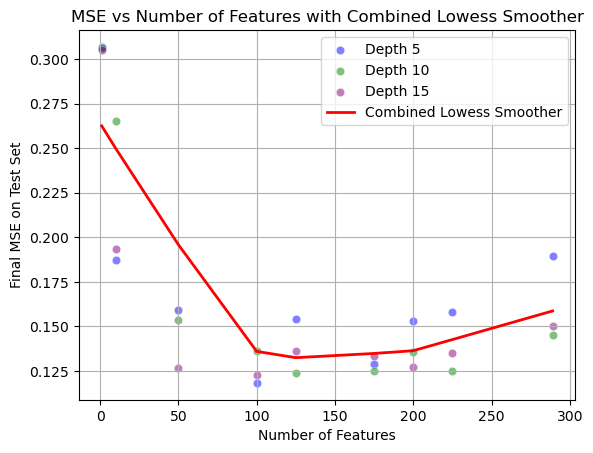

In [7]:
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

depths_to_try = [5, 10, 15]

# Create the scatter plot
plt.figure()

# Loop over different depths and assign a unique color
depth_colors = ['blue', 'green', 'purple']  # Add more colors if needed
for i, depth in enumerate(depths_to_try):
    depth_df = results_df[results_df['Depth'] == depth]
    sns.scatterplot(x='Num_Features', y='Final_MSE', data=depth_df,
                    label=f'Depth {depth}', color=depth_colors[i], alpha=0.5)

# Compute the lowess smoother for all depths combined
combined_lowess = sm.nonparametric.lowess(results_df['Final_MSE'], results_df['Num_Features'])
combined_lowess_x, combined_lowess_y = combined_lowess.T

# Plot the lowess smoother
plt.plot(combined_lowess_x, combined_lowess_y, color='red', label='Combined Lowess Smoother', linewidth=2)

plt.xlabel('Number of Features')
plt.ylabel('Final MSE on Test Set')
plt.title('MSE vs Number of Features with Combined Lowess Smoother')
plt.grid(True)
plt.legend()

# Save the figure
plt.savefig("f1_score_vs_num_features_RF_regression.png")

# Show the plot
plt.show()


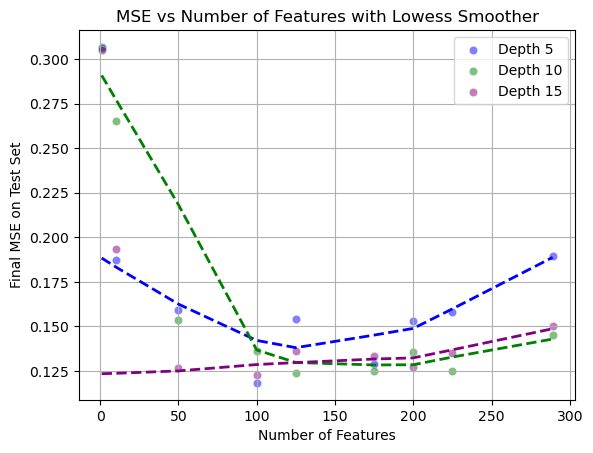

In [8]:
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

depths_to_try = [5, 10, 15]

# Create the scatter plot
plt.figure()

# Loop over different depths and assign a unique color
depth_colors = ['blue', 'green', 'purple']  # Add more colors if needed
for i, depth in enumerate(depths_to_try):
    depth_df = results_df[results_df['Depth'] == depth]
    sns.scatterplot(x='Num_Features', y='Final_MSE', data=depth_df,
                    label=f'Depth {depth}', color=depth_colors[i], alpha=0.5)

    # Compute the lowess smoother for each depth
    lowess_smooth = sm.nonparametric.lowess(depth_df['Final_MSE'], depth_df['Num_Features'])
    lowess_smooth_x, lowess_smooth_y = lowess_smooth.T

    # Plot the lowess smoother for each depth with dotted line style
    plt.plot(lowess_smooth_x, lowess_smooth_y, color=depth_colors[i], linestyle='--', linewidth=2)

# Compute the combined lowess smoother for all depths combined
combined_lowess = sm.nonparametric.lowess(results_df['Final_MSE'], results_df['Num_Features'])
combined_lowess_x, combined_lowess_y = combined_lowess.T

# Plot the combined lowess smoother with solid red line style
#plt.plot(combined_lowess_x, combined_lowess_y, color='red', label='Combined Lowess Smoother', linewidth=2)

plt.xlabel('Number of Features')
plt.ylabel('Final MSE on Test Set')
plt.title('MSE vs Number of Features with Lowess Smoother')
plt.grid(True)
plt.legend()

# Save the figure
plt.savefig("f1_score_vs_num_features_RF_regression_split.png")

# Show the plot
plt.show()


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import pearsonr

pearson_corr, p_value = pearsonr(depth_df['Final_MSE'], depth_df['Num_Features'])
print(f"Pearson Correlation Coefficient: {pearson_corr}")
print(f"P-value: {p_value}")

Pearson Correlation Coefficient: -0.5573347698691457
P-value: 0.11899321159784436
